In [2]:
# Import libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold,cross_val_score,cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from math import sqrt
from IPython.display import display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth', None)

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('final_data.csv')
train.head()

,Date_TimeCaught,year,week_of_year,year_woy,CaptureSite,Capture_Number
0,2000-01-01,2000,52,200052,CaptureSite_0,0.0
1,2000-12-18,2000,51,200051,CaptureSite_0,1.0
2,2001-01-01,2001,1,200101,CaptureSite_0,0.0
3,2001-01-08,2001,2,200102,CaptureSite_0,0.0
4,2001-01-15,2001,3,200103,CaptureSite_0,0.0


In [4]:
pred_2019 = pd.read_csv('submission_data.csv')
pred_2019 .head()

,Date_TimeCaught,year,week_of_year,year_woy,CaptureSite,Capture_Number
0,2019-01-01,2019,1,201901,CaptureSite_0,0.0
1,2019-01-07,2019,2,201902,CaptureSite_0,0.0
2,2019-01-14,2019,3,201903,CaptureSite_0,0.0
3,2019-01-21,2019,4,201904,CaptureSite_0,0.0
4,2019-01-28,2019,5,201905,CaptureSite_0,0.0


In [5]:
categ = pd.read_csv('data/CaptureSite_category.csv')
categ.head()

,CaptureSite,CaptureSiteCategory,Type
0,CaptureSite_0,CaptureSiteCategory_2,Type_1
1,CaptureSite_1,CaptureSiteCategory_2,Type_1
2,CaptureSite_10,CaptureSiteCategory_2,Type_1
3,CaptureSite_11,CaptureSiteCategory_0,Type_0
4,CaptureSite_12,CaptureSiteCategory_2,Type_1


In [6]:
train['Date_TimeCaught'] = pd.to_datetime(train['Date_TimeCaught'], format='%Y-%m-%d')
pred_2019['Date_TimeCaught'] = pd.to_datetime(pred_2019['Date_TimeCaught'], format='%Y-%m-%d')

#############################################################################################

train['day_of_year']= pd.DatetimeIndex(train['Date_TimeCaught']).dayofyear
pred_2019['day_of_year']= pd.DatetimeIndex(pred_2019['Date_TimeCaught']).dayofyear
train['month'] = train['Date_TimeCaught'].dt.month
pred_2019['month'] = pred_2019['Date_TimeCaught'].dt.month
train['day_of_week_caught'] = pd.DatetimeIndex(train['Date_TimeCaught']).dayofweek
pred_2019['day_of_week_caught'] = pd.DatetimeIndex(pred_2019['Date_TimeCaught']).dayofweek

###########################################################################################

train['day_of_month'] = pd.DatetimeIndex(train['Date_TimeCaught']).day
pred_2019['day_of_month'] = pd.DatetimeIndex(pred_2019['Date_TimeCaught']).day

In [7]:
train = pd.merge(categ, train, on='CaptureSite')
train.head()

,CaptureSite,CaptureSiteCategory,Type,Date_TimeCaught,year,week_of_year,year_woy,Capture_Number,day_of_year,month,day_of_week_caught,day_of_month
0,CaptureSite_0,CaptureSiteCategory_2,Type_1,2000-01-01,2000,52,200052,0.0,1,1,5,1
1,CaptureSite_0,CaptureSiteCategory_2,Type_1,2000-12-18,2000,51,200051,1.0,353,12,0,18
2,CaptureSite_0,CaptureSiteCategory_2,Type_1,2001-01-01,2001,1,200101,0.0,1,1,0,1
3,CaptureSite_0,CaptureSiteCategory_2,Type_1,2001-01-08,2001,2,200102,0.0,8,1,0,8
4,CaptureSite_0,CaptureSiteCategory_2,Type_1,2001-01-15,2001,3,200103,0.0,15,1,0,15


In [8]:
pred_2019 = pd.merge(categ, pred_2019, on='CaptureSite')
pred_2019.head()

,CaptureSite,CaptureSiteCategory,Type,Date_TimeCaught,year,week_of_year,year_woy,Capture_Number,day_of_year,month,day_of_week_caught,day_of_month
0,CaptureSite_0,CaptureSiteCategory_2,Type_1,2019-01-01,2019,1,201901,0.0,1,1,1,1
1,CaptureSite_0,CaptureSiteCategory_2,Type_1,2019-01-07,2019,2,201902,0.0,7,1,0,7
2,CaptureSite_0,CaptureSiteCategory_2,Type_1,2019-01-14,2019,3,201903,0.0,14,1,0,14
3,CaptureSite_0,CaptureSiteCategory_2,Type_1,2019-01-21,2019,4,201904,0.0,21,1,0,21
4,CaptureSite_0,CaptureSiteCategory_2,Type_1,2019-01-28,2019,5,201905,0.0,28,1,0,28


In [9]:
# Extract the second part of "CaptureSiteCategory" and convert to int
train["CaptureSiteCategory"] = train["CaptureSiteCategory"].str.split("_", expand=True)[1].astype(int)
pred_2019["CaptureSiteCategory"] = pred_2019["CaptureSiteCategory"].str.split("_", expand=True)[1].astype(int)

# Extract the second part of "Type" and convert to int
train["Type"] = train["Type"].str.split("_", expand=True)[1].astype(int)
pred_2019["Type"] = pred_2019["Type"].str.split("_", expand=True)[1].astype(int)

# Extract the second part of "CaptureSite" and convert to int
train["CaptureSite_id"] = train["CaptureSite"].str.split("_", expand=True)[1].astype(int)
pred_2019["CaptureSite_id"] = pred_2019["CaptureSite"].str.split("_", expand=True)[1].astype(int)

In [10]:
train.head()

,CaptureSite,CaptureSiteCategory,Type,Date_TimeCaught,year,week_of_year,year_woy,Capture_Number,day_of_year,month,day_of_week_caught,day_of_month,CaptureSite_id
0,CaptureSite_0,2,1,2000-01-01,2000,52,200052,0.0,1,1,5,1,0
1,CaptureSite_0,2,1,2000-12-18,2000,51,200051,1.0,353,12,0,18,0
2,CaptureSite_0,2,1,2001-01-01,2001,1,200101,0.0,1,1,0,1,0
3,CaptureSite_0,2,1,2001-01-08,2001,2,200102,0.0,8,1,0,8,0
4,CaptureSite_0,2,1,2001-01-15,2001,3,200103,0.0,15,1,0,15,0


In [10]:
'''# Creating a list of categorical features
categorical_features = ['CaptureSite', 'CaptureSiteCategory', 'Type']

# Converting categorical columns to category datatype
for col in categorical_features:
  train[col] = train[col].astype('category')
  pred_2019[col] = pred_2019[col].astype('category')

train.head()'''

"# Creating a list of categorical features\ncategorical_features = ['CaptureSite', 'CaptureSiteCategory', 'Type']\n\n# Converting categorical columns to category datatype\nfor col in categorical_features:\n  train[col] = train[col].astype('category')\n  pred_2019[col] = pred_2019[col].astype('category')\n\ntrain.head()"

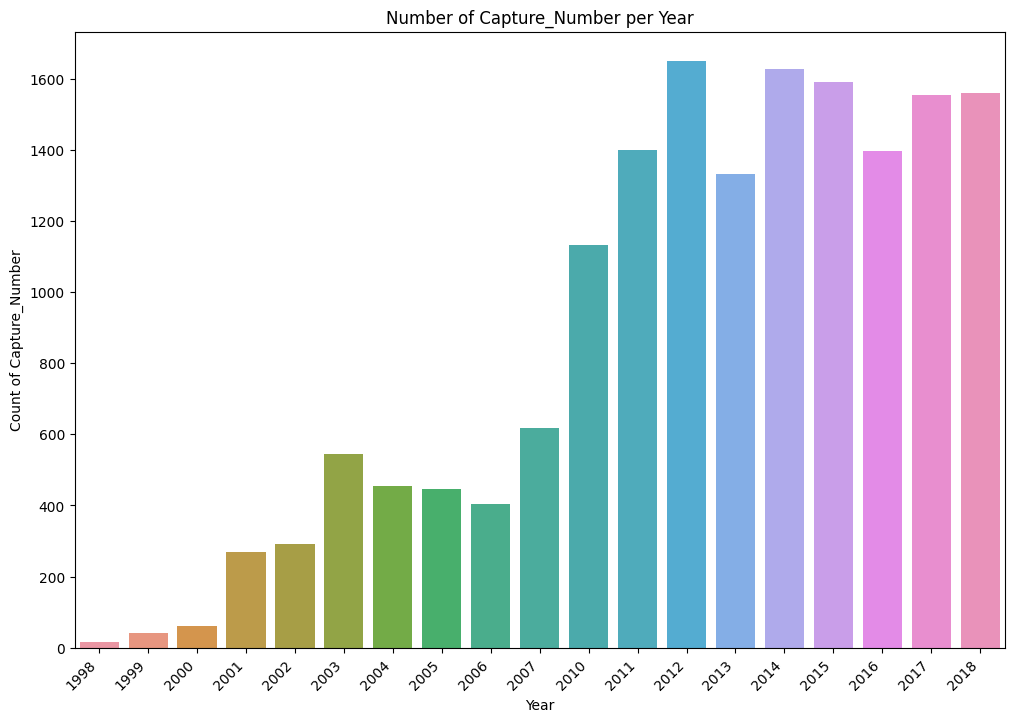

In [89]:
rescue_and_years = train[['Capture_Number', 'year']]


rescue_and_years['sum'] = rescue_and_years.groupby('year')['Capture_Number'].transform('sum')

fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x='year', y='sum', data=rescue_and_years, ax=ax)
plt.title('Number of Capture_Number per Year')
plt.xlabel('Year')
plt.ylabel('Count of Capture_Number')
plt.xticks(rotation=45, ha='right')
plt.show()

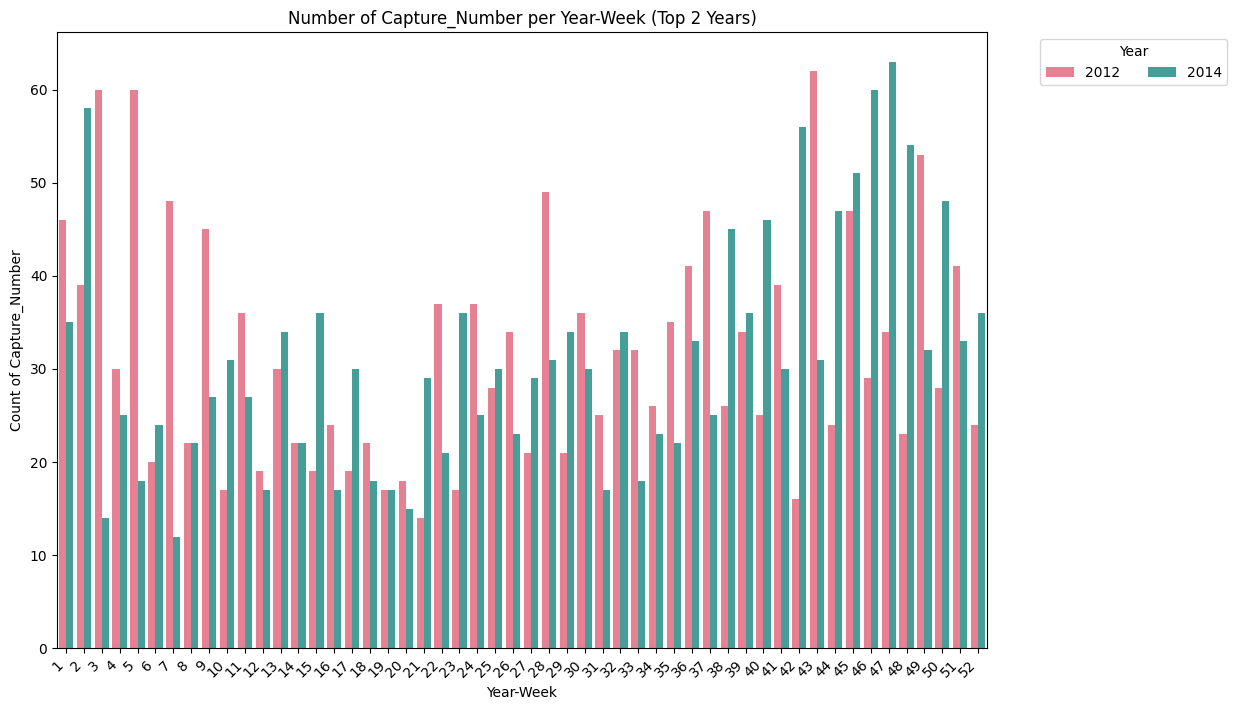

In [95]:

capture_counts = train.groupby(['week_of_year', 'year'])['Capture_Number'].sum().reset_index()


top_years = capture_counts.groupby('year')['Capture_Number'].sum().nlargest(2).index


capture_counts_top = capture_counts[capture_counts['year'].isin(top_years)]
capture_counts_top_up_to_week44 = capture_counts_top[capture_counts_top['week_of_year'] <= 44]

plt.figure(figsize=(12, 8))
sns.barplot(x='week_of_year', y='Capture_Number', hue='year', data=capture_counts_top, palette='husl', linewidth=2)
plt.title('Number of Capture_Number per Year-Week (Top 2 Years)')
plt.xlabel('Year-Week')
plt.ylabel('Count of Capture_Number')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2) 
plt.show()

In [96]:
#train = train[(train['year'] < 1998) | (train['year'] >= 2010)]

In [99]:
X = train.drop(['Capture_Number','Date_TimeCaught', 'CaptureSite'], axis=1)
incol = train.drop(['Capture_Number','Date_TimeCaught', 'CaptureSite'], axis=1).columns
y  = train.Capture_Number
ycol = 'Capture_Number'

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Best Parameters: {'fit_intercept': True, 'positive': False}


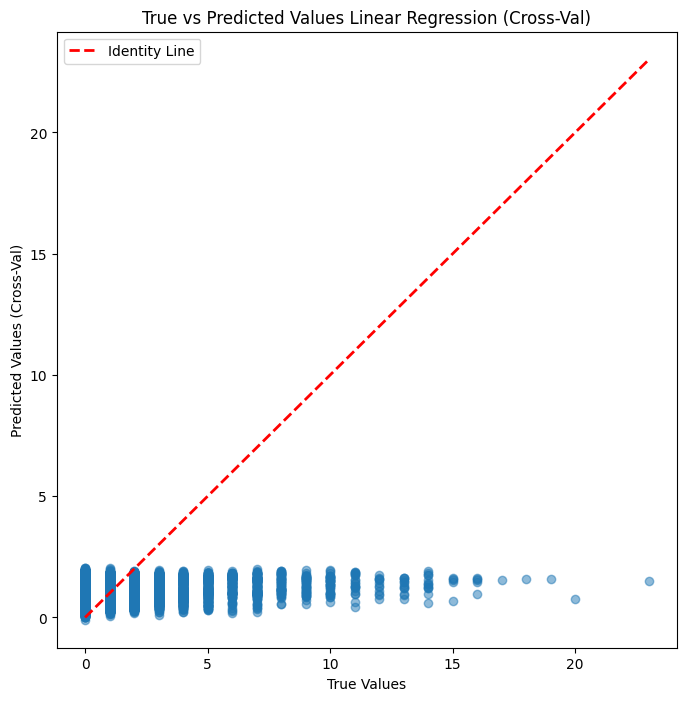

In [100]:


# Define your linear regression model
lr_model = LinearRegression()

# Define the parameter grid
param_grid = {'fit_intercept': [True, False], 'positive': [True, False]}

# Create a KFold cross-validation object
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Create a GridSearchCV object with cross-validation
lr_grid_search = GridSearchCV(lr_model, param_grid, cv=kf, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the data
lr_grid_search.fit(X, y)

# Print the best hyperparameters
print("Best Parameters:", lr_grid_search.best_params_)

# Get the best model from the grid search
best_lr_model = lr_grid_search.best_estimator_

# Make predictions using cross-validation
y_pred_cv_lr = cross_val_predict(best_lr_model, X, y, cv=kf)

# Scatter plot of true vs predicted values on the training set
plt.figure(figsize=(8, 8))
plt.scatter(y, y_pred_cv_lr, alpha=0.5)
plt.plot([min(y), max(y)], [min(y), max(y)], linestyle='--', color='red', linewidth=2, label='Identity Line')
plt.xlabel('True Values')
plt.ylabel('Predicted Values (Cross-Val)')
plt.title('True vs Predicted Values Linear Regression (Cross-Val)')
plt.legend()
plt.show()

RMSE: 0.5479317513958423


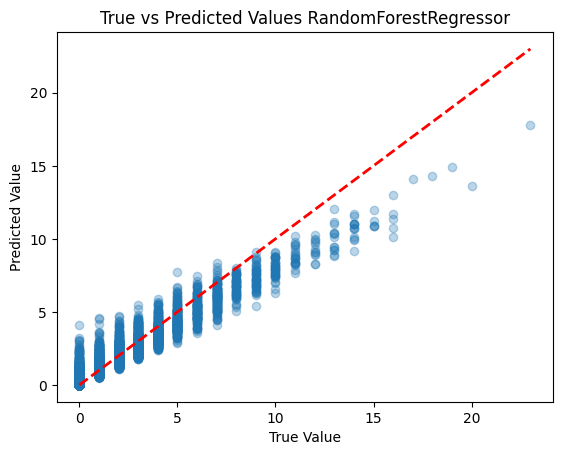

In [101]:
rf_model = RandomForestRegressor(n_estimators=100) 
rf_model.fit(X, y)
y_pred_rf = rf_model.predict(X)
print("RMSE:", sqrt(mean_squared_error(y, y_pred_rf)))

plt.scatter(y, y_pred_rf, alpha=0.3)
plt.plot([min(y), max(y)], [min(y), max(y)], linestyle='--', color='red', linewidth=2)
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.title('True vs Predicted Values RandomForestRegressor')
plt.show()

In [18]:
pred_2019['Capture_Number'] = rf_model.predict(pred_2019[incol])
pred_2019['Capture_Number'] = pred_2019['Capture_Number'].round()
pred_2019['ID'] = pred_2019["CaptureSite"]+ "_" + pred_2019["year_woy"].map(str)
pred_2019[['ID', 'Capture_Number']].to_csv('submission_rf_k.csv', index=False)

RMSE on Training Set: 0.46227522277382876


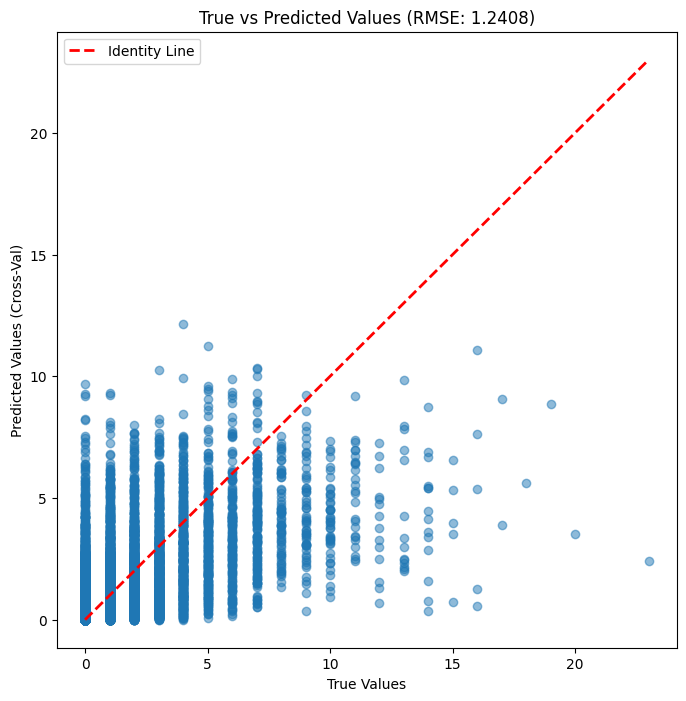

In [19]:
# Initialize your Random Forest regressor with specific hyperparameters
rf_model = RandomForestRegressor(n_estimators=100)

# Fit the Random Forest model on the entire dataset
rf_model.fit(X, y)

# Make predictions on the training set
y_pred_rf = rf_model.predict(X)

# Print the RMSE on the training set
print("RMSE on Training Set:", sqrt(mean_squared_error(y, y_pred_rf)))

# Perform cross-validation and get predicted values
kf = KFold(n_splits=5, shuffle=True, random_state=42)
y_pred_cv_rf = cross_val_predict(rf_model, X, y, cv=kf)

# Scatter plot of true vs predicted values from cross-validation
plt.figure(figsize=(8, 8))
plt.scatter(y, y_pred_cv_rf, alpha=0.5)
plt.plot([min(y), max(y)], [min(y), max(y)], linestyle='--', color='red', linewidth=2, label='Identity Line')
plt.xlabel('True Values')
plt.ylabel('Predicted Values (Cross-Val)')
plt.title('True vs Predicted Values (RMSE: {:.4f})'.format(sqrt(mean_squared_error(y, y_pred_cv_rf))))
plt.legend()
plt.show()

In [22]:
pred_2019['Capture_Number'] = pred_2019['Capture_Number'] = rf_model.predict(pred_2019[incol])
pred_2019['ID'] = pred_2019["CaptureSite"]+ "_" + pred_2019["year_woy"].map(str)
pred_2019[['ID', 'Capture_Number']].to_csv('submission.csv', index=False)

Best Hyperparameters: {'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
RMSE on Test Set: 1.0858342440397284


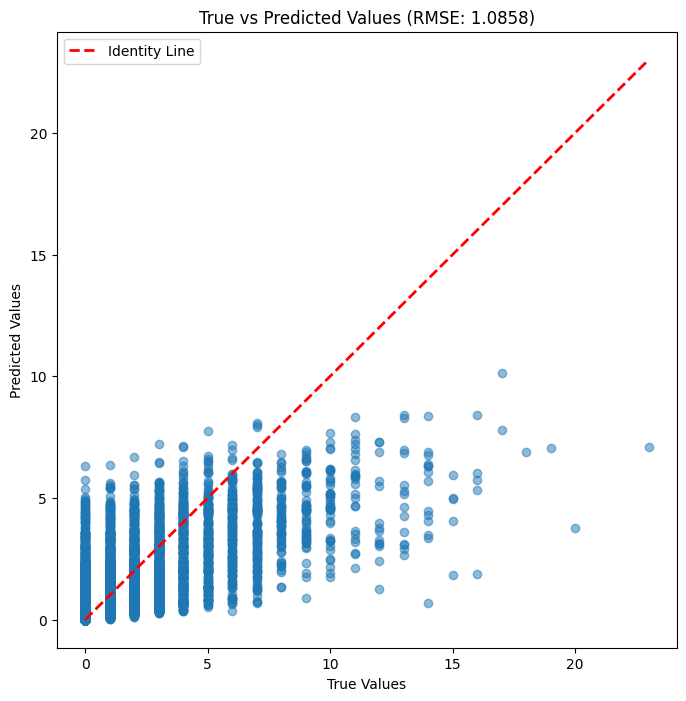

In [23]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 9, 10, 20],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# Fit the GridSearchCV object to the data
grid_search.fit(train[incol],train[ycol])#(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Get the best model from the grid search
best_rf_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred_rf = best_rf_model.predict(train[incol])#(X_test)

# Evaluate the model
rmse_rf = sqrt(mean_squared_error(train[ycol], y_pred_rf))
print("RMSE on Test Set:", rmse_rf)

# Scatter plot of true vs predicted values on the training set
plt.figure(figsize=(8, 8))
plt.scatter(train[ycol], y_pred_rf, alpha=0.5)
plt.plot([min(train[ycol]), max(train[ycol])], [min(train[ycol]), max(train[ycol])], linestyle='--', color='red', linewidth=2, label='Identity Line')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values (RMSE: {:.4f})'.format(sqrt(mean_squared_error(train[ycol],y_pred_rf))))
plt.legend()
plt.show()

In [104]:
pred_2019['Capture_Number'] = best_rf_model.predict(pred_2019[incol])
pred_2019['ID'] = pred_2019["CaptureSite"]+ "_" + pred_2019["year_woy"].map(str)
pred_2019[['ID', 'Capture_Number']].to_csv('submission_rf_2010.csv', index=False)

RMSE Scores for each fold: [1.493968   1.53177024 1.32105384 1.45354885 1.37472352 1.31973789
 1.48511192 1.4393831  1.45146222 1.44647926]
Average RMSE: 1.4317238842240119


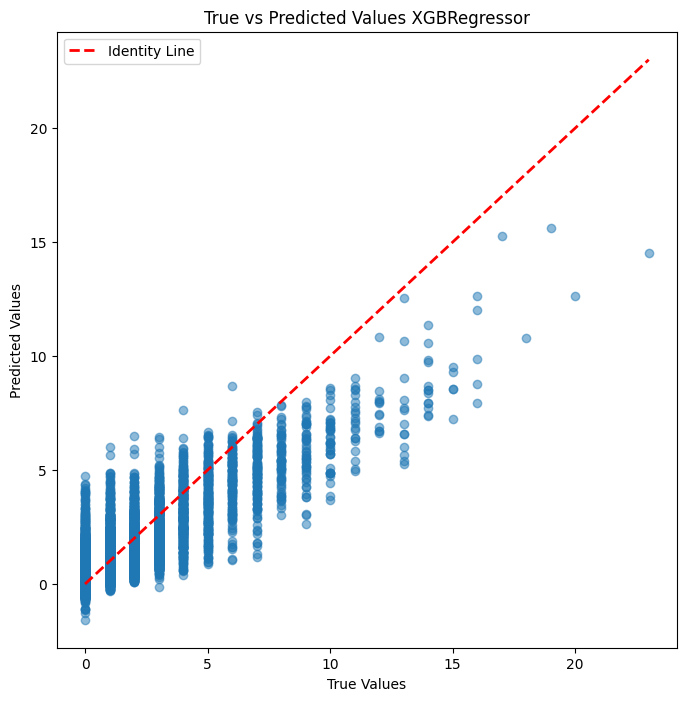

In [102]:
# Initialize your XGBoost regressor
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Set the number of folds for cross-validation (e.g., 5-fold)
num_folds = 10

# Create a KFold cross-validation object
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform cross-validation and calculate the RMSE for each fold
rmse_scores = np.sqrt(-cross_val_score(xgb_model, train[incol], train[ycol], scoring='neg_mean_squared_error', cv=kf))

# Display the RMSE scores for each fold
print("RMSE Scores for each fold:", rmse_scores)

# Calculate and display the average RMSE across all folds
average_rmse = np.mean(rmse_scores)
print("Average RMSE:", average_rmse)

# Train the model on the entire dataset
xgb_model.fit(train[incol], train[ycol])

# Make predictions on the training set
y_pred_train = xgb_model.predict(train[incol])

# Scatter plot of true vs predicted values on the training set
plt.figure(figsize=(8, 8))
plt.scatter(train[ycol], y_pred_train, alpha=0.5)
plt.plot([min(train[ycol]), max(train[ycol])], [min(train[ycol]), max(train[ycol])], linestyle='--', color='red', linewidth=2, label='Identity Line')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values XGBRegressor')
plt.legend()
plt.show()

Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}


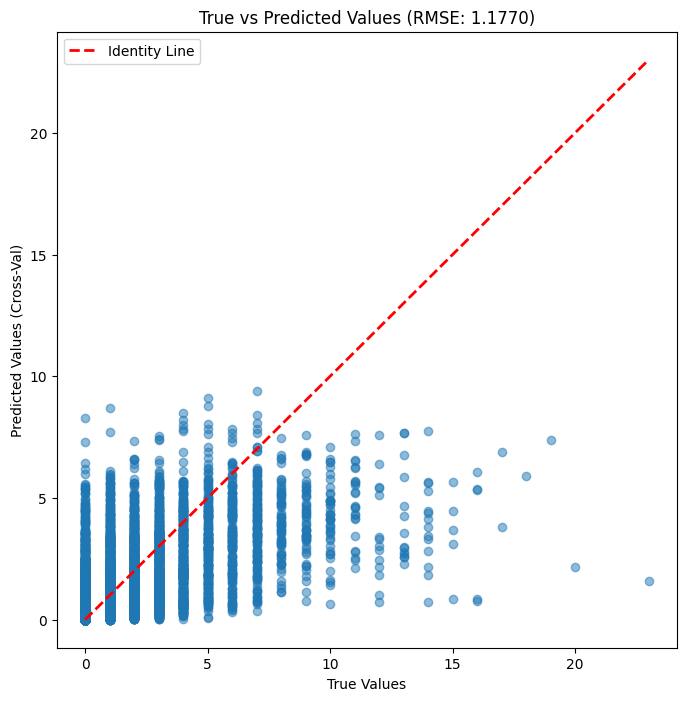

In [26]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 9, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize your Random Forest regressor
rf_model = RandomForestRegressor(random_state=42)

# Create a KFold cross-validation object
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Create a GridSearchCV object with cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=kf)

# Fit the GridSearchCV object to the data
grid_search.fit(X, y)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Get the best model from the grid search
best_rf_model = grid_search.best_estimator_

# Perform cross-validation and get predicted values
y_pred_cv = cross_val_predict(best_rf_model, X, y, cv=kf)

# Scatter plot of true vs predicted values from cross-validation
plt.figure(figsize=(8, 8))
plt.scatter(y, y_pred_cv, alpha=0.5)
plt.plot([min(y), max(y)], [min(y), max(y)], linestyle='--', color='red', linewidth=2, label='Identity Line')
plt.xlabel('True Values')
plt.ylabel('Predicted Values (Cross-Val)')
plt.title('True vs Predicted Values (RMSE: {:.4f})'.format(sqrt(mean_squared_error(y, y_pred_cv))))
plt.legend()
plt.show()

Best Hyperparameters: {'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
RMSE Scores for each fold: [1.97872932 1.93241182 2.22168938 2.0130622  1.8596139  1.6634642
 2.16408413 1.92972068 1.96553093 1.99490521 1.8177595  1.89365326
 2.05254265 1.97534191 2.07598808 1.83063108 2.00211825 2.26361323
 1.92429425 2.02753394]
Average RMSE: 1.9793343965335233


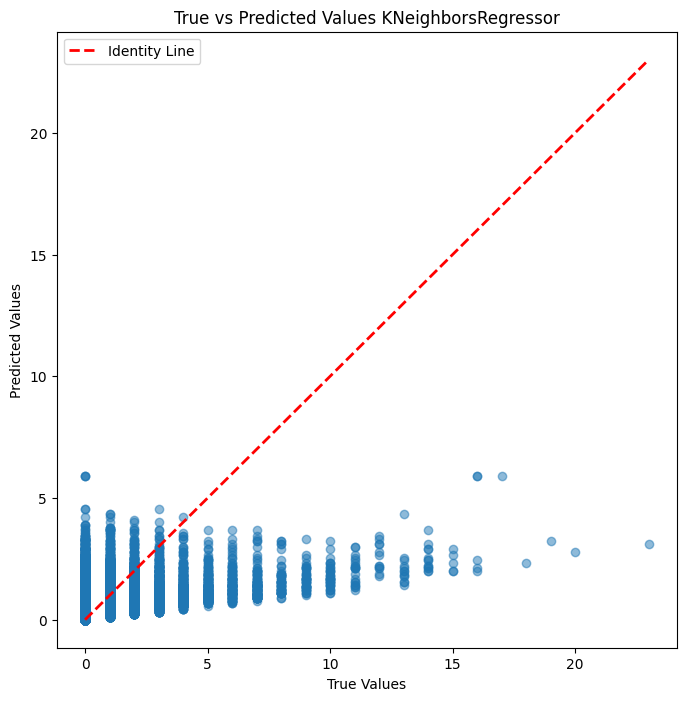

In [114]:

param_grid = {
    'n_neighbors': [3, 5, 7, 9],  
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3]  # 1 for Manhattan distance, 2 for Euclidean distance
}

# Initialize your KNN regressor
knn_model = KNeighborsRegressor()

# Perform grid search with cross-validation
grid_search = GridSearchCV(knn_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

# Get the best model from the grid search
best_knn_model = grid_search.best_estimator_

# Display the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Set the number of folds for cross-validation (e.g., 5-fold)
num_folds = 20

# Create a KFold cross-validation object
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform cross-validation and calculate the RMSE for each fold using the best model
rmse_scores = np.sqrt(-cross_val_score(best_knn_model, X, y, scoring='neg_mean_squared_error', cv=kf))

# Display the RMSE scores for each fold
print("RMSE Scores for each fold:", rmse_scores)

# Calculate and display the average RMSE across all folds
average_rmse = np.mean(rmse_scores)
print("Average RMSE:", average_rmse)

# Train the best model on the entire dataset
best_knn_model.fit(X, y)

# Make predictions on the training set
y_pred_train = best_knn_model.predict(X)

# Scatter plot of true vs predicted values on the training set
plt.figure(figsize=(8, 8))
plt.scatter(y, y_pred_train, alpha=0.5)
plt.plot([min(y), max(y)], [min(y), max(y)], linestyle='--', color='red', linewidth=2, label='Identity Line')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values KNeighborsRegressor')
plt.legend()
plt.show()

In [105]:
final_pred = pd.read_csv('submission_rf_2010.csv')
final_pred.head()

,ID,Capture_Number
0,CaptureSite_0_201901,0.470596
1,CaptureSite_0_201902,0.540151
2,CaptureSite_0_201903,0.505762
3,CaptureSite_0_201904,0.439033
4,CaptureSite_0_201905,0.388002


In [106]:
final_pred.Capture_Number.sum()

1654.2698433504315

In [107]:
final_pred[['CaptureSite', 'nr_capturesite','yearweek']] = final_pred['ID'].str.split('_', expand=True)

In [108]:
max_capture_per_week = final_pred.groupby(['yearweek'],as_index=False)['Capture_Number'].sum()

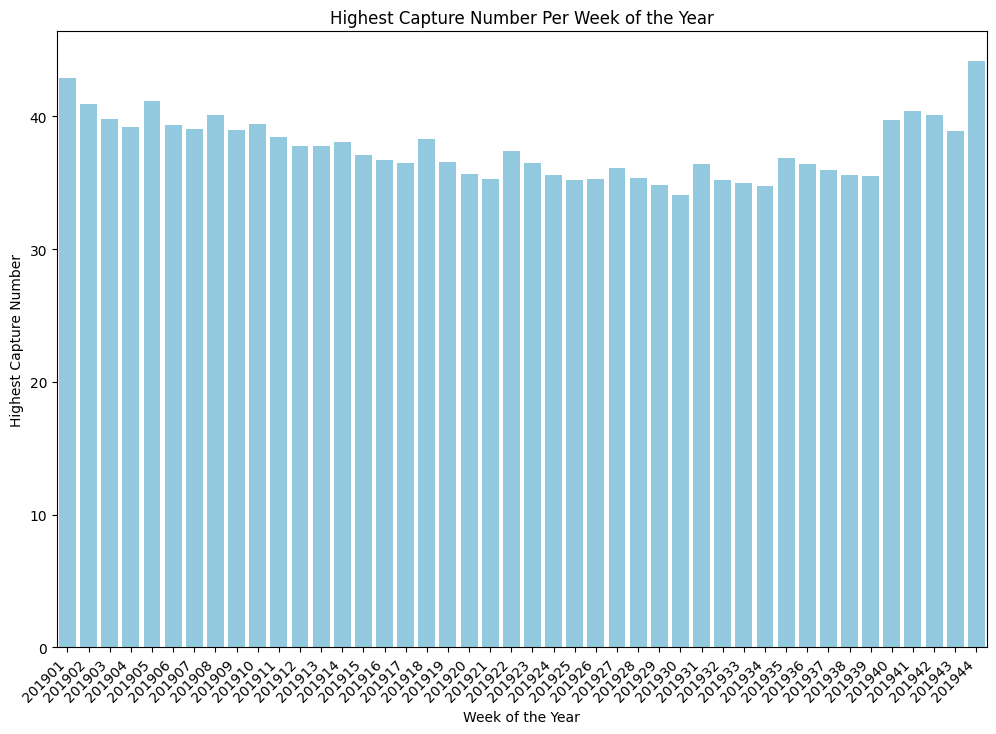

In [109]:
plt.figure(figsize=(12, 8))
sns.barplot(x='yearweek', y='Capture_Number', data=max_capture_per_week, color='skyblue')
plt.title('Highest Capture Number Per Week of the Year')
plt.xlabel('Week of the Year')
plt.ylabel('Highest Capture Number')
plt.xticks(rotation=45, ha='right')  # Adjust the rotation angle as needed
plt.show()

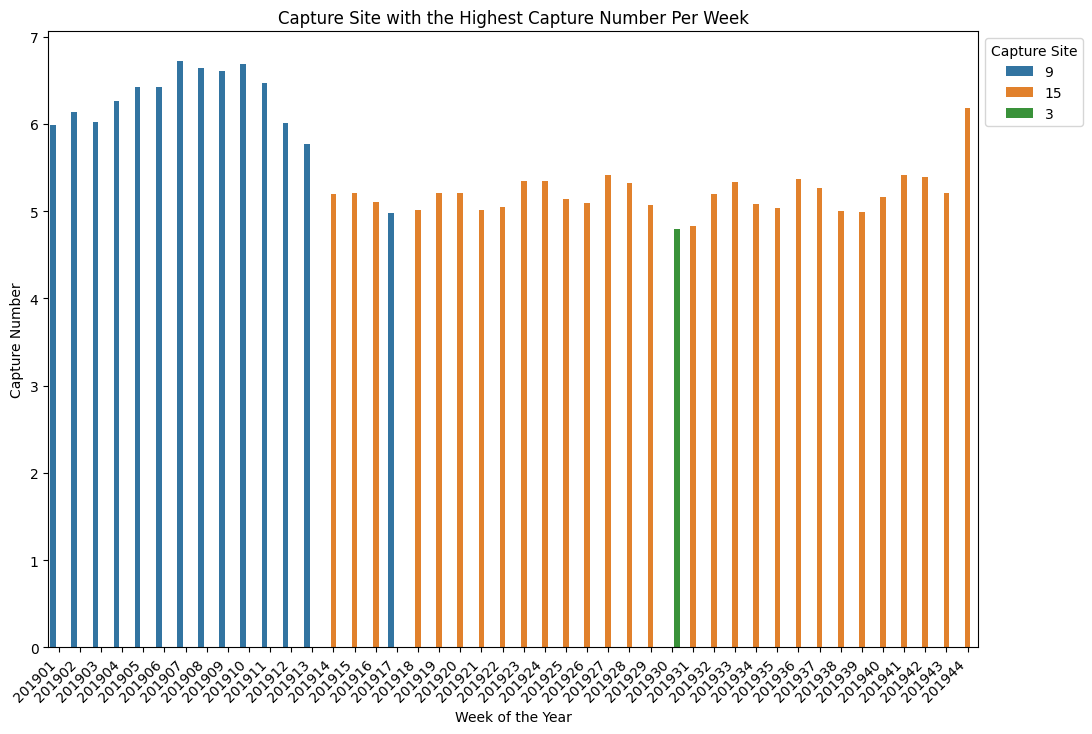

In [110]:

max_capture_per_week = final_pred.loc[final_pred.groupby('yearweek')['Capture_Number'].idxmax()]
# Bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x='yearweek', y='Capture_Number', hue='nr_capturesite', data=max_capture_per_week)
plt.title('Capture Site with the Highest Capture Number Per Week')
plt.xlabel('Week of the Year')
plt.ylabel('Capture Number')
plt.legend(title='Capture Site', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45, ha='right')  # Adjust the rotation angle as needed
plt.show()